In [134]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.tree import DecisionTreeClassifier

from math import sqrt

from sklearn import svm

In [ ]:
def preprocess(df: pd.DataFrame, cols_ord=[], cats_ord=[], cols_nom=[], cols_num=[]):
    cols_ord_ = list(set(cols_ord) & set(df.columns))
    cats_ord_ = [cats_ord[cols_ord.index(col)] for col in cols_ord_]
    cols_nom_ = list(set(cols_nom) & set(df.columns))
    cols_num_ = list(set(cols_num) & set(df.columns))

    transformers = []
    if cols_ord_:
        transform = (OrdinalEncoder(categories=cats_ord_), cols_ord_)
        transformers.append(transform)
    if cols_nom_:
        transform = (OneHotEncoder(), cols_nom_)
        transformers.append(transform)
    if cols_num_:
        transform = (StandardScaler(), cols_num_)
        transformers.append(transform)

    if transformers:
        steps = [("transformer", make_column_transformer(*transformers))]
        return Pipeline(steps).fit_transform(df)
    else:
        return df.to_numpy()


def search(X, y, path=None, read_cache=True, n_jobs=-1):
    try:
        if path is not None and read_cache:
            with open(path, "rb") as file:
                results = pickle.load(file)
        else:
            raise FileNotFoundError()
    except FileNotFoundError:
        pipe = Pipeline([("estimator", LogisticRegression())])
        search = GridSearchCV(
            pipe,
            param_grid=[
                {
                    "estimator": [LogisticRegression()],
                    "estimator__penalty": ["l1"]},
                {
                    "estimator": [DecisionTreeClassifier()],
                    "estimator__max_depth": [10, 20, None],
                },
                {
                    "estimator": [RandomForestClassifier()],
                    "estimator__n_estimators": [100, 250, 1000],
                },
            ],
            n_jobs=n_jobs,
            scoring="f1_micro",
        )
        _ = search.fit(X, y)
        results = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score", ascending=False
        )
        if path is not None:
            with open(path, "wb") as file:
                pickle.dump(results, file)

    return results

### Carregamento dos dados

In [46]:
# Características
df_sociais = pd.read_csv("data/trabalho5_dados_sociais_4.csv")
df_modulo1 = pd.read_csv("data/trabalho5_dados_modulo1_4.csv")
df_modulo2 = pd.read_csv("data/trabalho5_dados_ateh_modulo2_4.csv")

class_names = ['Aprovado', 'Não Aprovado']

### Análise exploratória

#### Relações entre características

In [ ]:
# TODO

#### Relações entre características e rótulos

In [ ]:
# TODO

### Pré-processamento inicial

In [ ]:
# Rótulos
y = LabelEncoder().fit(["Não", "Sim"]).transform(df_modulo2["aprovado"])
df_sociais = df_sociais.drop(["id", "aprovado"], axis=1)
df_modulo1 = df_modulo1.drop(["id", "aprovado"], axis=1)
df_modulo2 = df_modulo2.drop(["id", "aprovado"], axis=1)

In [ ]:
# Ordens das categorias
sn_cat = ["Não", "Sim"]
sexo_cat = ["Feminino", "Masculino"]
escolaridade_cat = [
    "Ensino Médio Completo",
    "Ensino Superior Incompleto",
    "Ensino Superior Completo",
    "Pós-graduação",
]
materialdidatico_cat = ["Adequado", "Muito adequado"]
prazoatividades_cat = [
    "Pouquíssimo flexível",
    "Pouco flexível",
    "Flexível",
    "Muito flexível",
]
interacaopares_cat = ["Importante", "Muito importante"]
organizacaocurso_cat = ["Organizado", "Muito organizado"]
import_ajud_tutor_cat = ["Às vezes", "Sempre"]
autoavaliacao_cat = [
    "Não, não considero",
    "Sim, considero, porém, poderia estar me esforçando mais",
    "Sim, considero",
]
pp_cat = [
    "Discordo totalmente",
    "Discordo",
    "Nem discordo, nem concordo",
    "Concordo",
    "Concordo totalmente",
]

In [ ]:
# Variáveis ordinais
cols_ord = [
    "escolaridade",
    "materialdidatico",
    "prazoatividades",
    "interacaopares",
    "import.ajud.tutor",
    "autoavaliacao.x",
] + [f"pp{n + 1:03}" for n in range(37)]
cats_ord = [
    escolaridade_cat,
    materialdidatico_cat,
    prazoatividades_cat,
    interacaopares_cat,
    import_ajud_tutor_cat,
    autoavaliacao_cat,
] + [pp_cat] * 37

# Variáveis nominais
cols_nom = list(set(df_sociais.select_dtypes(object).columns) - set(cols_ord))

# Variáveis numéricas
cols_num = ["idade", "tempodeservico"]

### Funções

In [95]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()




In [74]:
def plot_roc_curve(X_test, y_test, y_predict, model, info):
    # Step 6: Predict probabilities for the test data.
    probs = model.predict_proba(X_test)#[:,1]
    # Step 7: Keep Probabilities of the positive class only.
    probs = probs[:, 1]
    # Step 8: Compute the AUC Score.
    auc = metrics.roc_auc_score(y_test, probs)
    print('\n----ROC Curve----\nAUC: %.2f' % auc)
    # Step 9: Get the ROC Curve.
    # false_positive_rate, true_positive_rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
    print(metrics.auc(fpr, tpr),'\n-----------------\n')
    # Step 10: Plot ROC Curve using our defined function


    plt.plot(fpr, tpr, color='red', label='ROC') #orange
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + info)
    plt.legend()
    plt.show()

In [76]:
def metrics_structure():
    results = pd.DataFrame({'Acuracy':[],
                            'Precision':[],
                            'Recall':[],
                            'F1-score':[],
                            'F-beta':[],
                            'TP':[],
                            'TN':[],
                            'ROC Curve':[]}, )
    results.index.names = ['Algoritmos']
    return results

In [137]:
#Feature Importances

def featureImportantes(bestModel, X, columns):
    print(bestModel.feature_importances_)
    height = bestModel.feature_importances_
    bars = columns
    y_pos = np.arange(len(bars))

    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars, rotation = 90)
    plt.show()

In [142]:
def cross_validation_stratified(X, y, model, name, columns, balancer = None):

    results_cv = metrics_structure()

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    auc_media = 0

    skfold = StratifiedKFold(n_splits=5)

    for fold, (train_index, test_index) in enumerate(skfold.split(X, y), 1):

        X_train = X[train_index]
        y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
        X_test = X[test_index]
        y_test = y[test_index]  # See comment on ravel and  y_train
        if balancer is not None:
            X_train, y_train = balancer.fit_resample(X_train, y_train)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)


        acuracy = metrics.accuracy_score(y_test, y_predict)
        precision = metrics.precision_score(y_test, y_predict)
        recall = metrics.recall_score(y_test, y_predict)
        f_score = metrics.f1_score(y_test, y_predict)
        f_beta = metrics.fbeta_score(y_test, y_predict, beta=2)
        ROC = metrics.roc_auc_score(y_test, y_predict)
        TP = len(y_test[(y_test==1) & (y_predict==1)])
        TN = len(y_test[(y_test==0) & (y_predict==0)])

        tp += len(y_test[(y_test==1) & (y_predict==1)])
        tn += len(y_test[(y_test==0) & (y_predict==0)])
        fp += len(y_test[(y_test==0) & (y_predict==1)])
        fn += len(y_test[(y_test==1) & (y_predict==0)])

        auc_media += ROC

        result_fold = [acuracy, precision, recall, f_score, f_beta, TP, TN, ROC]
        results_cv = results_cv.append(pd.DataFrame([result_fold], index=[('Fold' + str(fold))], columns=results_cv.columns))

        if fold == 1:
            print('best fold', str(fold))
            bestMetric = acuracy
            bestModel = model
            X_test_best = X_test
            y_test_best = y_test
            y_predict_best = y_predict

        elif acuracy > bestMetric:
            print('best fold', str(fold))
            bestMetric = acuracy
            bestModel = model
            X_test_best = X_test
            y_test_best = y_test
            y_predict_best = y_predict


    plot_confusion_matrix(y_test, y_predict, classes=class_names, title=name)
    plot_roc_curve(X_test_best, y_test_best, y_predict_best, model, name)

    acur = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp)
    reca = tp/(tp+fn)
    f1sc = (2*reca*prec)/(reca+prec)
    f2sc = (5*reca*prec)/((4*prec)+reca)
    auc_media /= 10


    results_metrics = metrics_structure()
    results = [acur, prec, reca, f1sc, f2sc, tp, tn, auc_media]
    results_metrics = results_metrics.append(pd.DataFrame([results], index=[name], columns=results_metrics.columns))

    return results_metrics, results_cv, bestModel

### Métricas de acurácia para DecisionTreeClassifier

- **Acurácia:** indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
  - Boa indicação geral de como o modelo performou
  - Pode haver situações em que ela é enganosa
  - Você estaria validando como ótimo um modelo que falha

#

- **Precisão:** dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
  - Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos

#

- **Recall/Revocação/Sensibilidade:** dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
  - Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos

#

- **F1-Score:** média harmônica entre precisão e recall.
  - Observar somente 1 métrica ao invés de duas (precisão e recall)
  - Está muito mais próxima dos menores valores do que uma média aritmética simples
  - F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo

#

- **F-Beta:**
   - Para dar mais peso a precisão, usamos um valor Beta no intervalo de 0 < Beta < 1
   - Para dar mais peso ao recall, usamos um valor Beta no intervalo 1 < Beta < +∞

#

- **AUC-ROC:**
  - A curva ROC é uma das métricas mais comuns para avaliar a performance de modelos, particularmente em casos de dados desbalanceados


![texte](https://miro.medium.com/max/1200/1*AaDv4AvGHSyfoU6_AYLXjA.png)

- **StratifiedKFold**
  - Pega a mesma proporção de cada classe 
  - É o padrão para uso no cv

### Situação 1 - Classificação: Dados socioeconômicos

In [208]:
X = df_sociais.copy()
columns = X.columns
X = preprocess(df_sociais, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 2


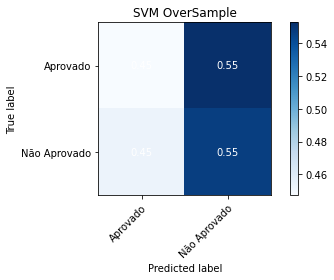


----ROC Curve----
AUC: 0.63
0.6321839080459769 
-----------------



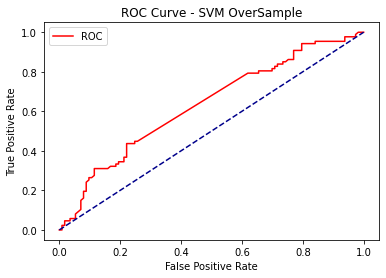

In [209]:
sampling = RandomOverSampler()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM OverSample', columns, sampling)

In [210]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM OverSample,0.49,0.426357,0.506912,0.463158,0.488455,220.0,270.0,0.246022


In [211]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.445,0.382353,0.448276,0.412698,0.433333,39.0,50.0,0.445377
Fold2,0.545,0.478261,0.505747,0.491620,0.500000,44.0,65.0,0.540484
Fold3,0.455,0.387755,0.436782,0.410811,0.426009,38.0,53.0,0.452904
Fold4,0.515,0.456140,0.597701,0.517413,0.562771,52.0,51.0,0.524514
Fold5,0.490,0.427273,0.546512,0.479592,0.517621,47.0,51.0,0.496940


In [212]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.515 0.494 0.492 0.488 0.481 0.48 ]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.008178,7.449895e-04,0.001596,4.885792e-04,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.565,0.570,0.410,0.510,0.520,0.515,0.057619,1
2,0.013962,3.152820e-03,0.001995,9.221592e-07,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.530,0.470,0.465,0.490,0.515,0.494,0.025179,2
3,0.014362,2.148402e-03,0.001396,4.882665e-04,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.545,0.490,0.455,0.460,0.510,0.492,0.033257,3
4,0.348443,7.357356e-02,0.017154,1.163358e-03,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.555,0.455,0.450,0.465,0.515,0.488,0.040694,4
5,0.760142,4.183091e-02,0.035910,6.960627e-03,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.545,0.445,0.425,0.485,0.505,0.481,0.042708,5
6,2.300607,1.243666e-01,0.107838,4.714162e-03,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.555,0.430,0.440,0.455,0.520,0.480,0.048888,6
0,0.000998,6.143617e-07,0.000000,0.000000e+00,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


### Situação 2 - Classificação: Dados socioeconômicos + primeiro módulo

In [204]:
X = pd.concat([df_sociais, df_modulo1], axis=1)
columns = X.columns
X = preprocess(X, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 2
best fold 4


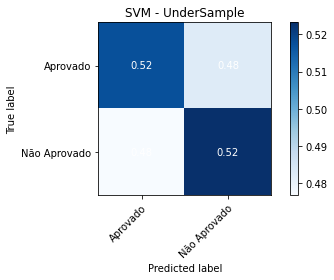


----ROC Curve----
AUC: 0.37
0.3748855660665243 
-----------------



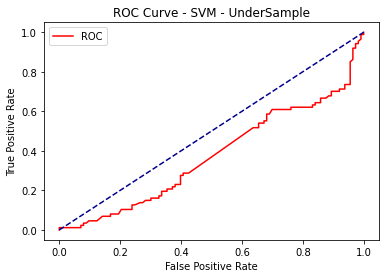

In [213]:
sampling = RandomUnderSampler()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM - UnderSample', columns, sampling)

In [214]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM - UnderSample,0.487,0.421158,0.486175,0.451337,0.471614,211.0,276.0,0.24346


In [215]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.455,0.390000,0.448276,0.417112,0.435268,39.0,52.0,0.454226
Fold2,0.510,0.451327,0.586207,0.510000,0.553145,51.0,51.0,0.518767
Fold3,0.425,0.351064,0.379310,0.364641,0.373303,33.0,52.0,0.419744
Fold4,0.525,0.457447,0.494253,0.475138,0.486425,43.0,62.0,0.521463
Fold5,0.520,0.450000,0.523256,0.483871,0.506757,45.0,59.0,0.520400


In [205]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.511 0.501 0.482 0.477 0.49  0.484]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.009374,0.002410,0.001795,0.000399,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.555,0.575,0.405,0.500,0.520,0.511,0.059110,1
2,0.013164,0.001827,0.001596,0.000488,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.555,0.485,0.475,0.495,0.495,0.501,0.028000,2
5,0.827162,0.074092,0.040501,0.005506,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.550,0.465,0.455,0.445,0.535,0.490,0.043589,3
6,2.545864,0.051595,0.105721,0.007333,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.555,0.455,0.445,0.455,0.510,0.484,0.042237,4
3,0.014361,0.002054,0.001596,0.000488,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.525,0.440,0.460,0.480,0.505,0.482,0.030430,5
4,0.320046,0.068889,0.026937,0.011195,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.520,0.430,0.455,0.445,0.535,0.477,0.042261,6
0,0.000599,0.000489,0.000000,0.000000,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


### Situação 3 - Classificação: Todos os dados

In [126]:
X = pd.concat([df_sociais, df_modulo1, df_modulo2], axis=1)
columns = X.columns
X = preprocess(X, cols_ord, cats_ord, cols_nom, cols_num)

best fold 1
best fold 2


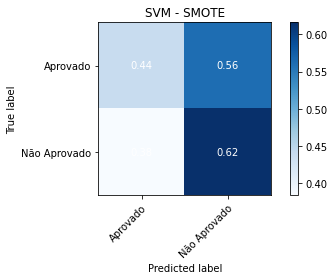


----ROC Curve----
AUC: 0.63
0.6341165700335671 
-----------------



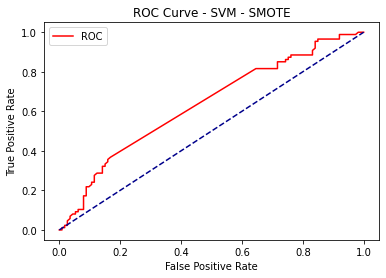

In [177]:
sampling = SMOTE()
clf = svm.SVC(kernel='linear', probability=True)
result, results_folds, bestModel = cross_validation_stratified(X, y, clf, 'SVM - SMOTE', columns, sampling)

In [178]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
SVM - SMOTE,0.483,0.423006,0.525346,0.468654,0.501099,228.0,255.0,0.244026


In [179]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.470,0.407767,0.482759,0.442105,0.465632,42.0,52.0,0.471468
Fold2,0.520,0.453608,0.505747,0.478261,0.494382,44.0,60.0,0.518360
Fold3,0.410,0.360360,0.459770,0.404040,0.435730,40.0,42.0,0.415726
Fold4,0.500,0.441441,0.563218,0.494949,0.533769,49.0,51.0,0.507273
Fold5,0.515,0.452991,0.616279,0.522167,0.574837,53.0,50.0,0.527438


In [180]:
search(X, y)

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [  nan 0.502 0.493 0.479 0.488 0.488 0.489]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__penalty,param_estimator__max_depth,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.009973,0.001261,0.001397,0.000489,DecisionTreeClassifier(max_depth=10),NaN,10,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.500,0.570,0.410,0.505,0.525,0.502,0.052211,1
2,0.012167,0.000977,0.001396,0.000489,DecisionTreeClassifier(max_depth=10),NaN,20,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.565,0.465,0.460,0.470,0.505,0.493,0.039319,2
6,2.473815,0.113204,0.108914,0.007059,RandomForestClassifier(),NaN,NaN,1000,"{'estimator': RandomForestClassifier(), 'estim...",0.545,0.450,0.455,0.470,0.525,0.489,0.038652,3
4,0.442616,0.105464,0.021946,0.006562,RandomForestClassifier(),NaN,NaN,100,"{'estimator': RandomForestClassifier(), 'estim...",0.545,0.460,0.430,0.485,0.520,0.488,0.041061,4
5,0.811707,0.126980,0.040816,0.004161,RandomForestClassifier(),NaN,NaN,250,"{'estimator': RandomForestClassifier(), 'estim...",0.575,0.460,0.440,0.455,0.510,0.488,0.049457,4
3,0.012366,0.001353,0.001397,0.000489,DecisionTreeClassifier(max_depth=10),NaN,None,NaN,{'estimator': DecisionTreeClassifier(max_depth...,0.515,0.450,0.465,0.470,0.495,0.479,0.023108,6
0,0.001795,0.000747,0.000000,0.000000,LogisticRegression(),l1,NaN,NaN,"{'estimator': LogisticRegression(), 'estimator...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
